<a id='Title-Intermediate-Time-Series-RNN'></a>
<h1 style="color:SlateGray;">Intermediate Time Series RNN</h1>

**Input dataset**

Max Plank Institute Weather Station Data: a set of 14 different weather quantities taken at 10-minute intervals from 2009-2016.

**Output classification**

The weather 24 hours from the last data point seen by the network.

<h2 style="color:SlateGray;">Background</h2>

**Layers**

[*Dense*](01_Image_Classification.ipynb#Layers-Dense)

[*LSTM*](12_Basic_NLP_RNN.ipynb#Layers-LSTM)

<a id='Layers-GRU'></a>
*GRU*

Conceptually similar to [LSTM](12_Basic_NLP_RNN.ipynb#Layers-LSTM), but does away with the internal state variable reducing some computational complexity, and by extension accuracy, for speed.

A running history list is kept external to the network and its values are used as input along with the network's most recent output to compute the next state.

<a id='Layers-Bidirectional'></a>
*Bidirectional*

Allows a model to see multiple interpretations of the same data, potentially developing a better-generalized interpretation of the data.

Instantiates two identical recurrent layers streaming samples from the dataset in forward and reverse order and combining the results of each model.

**Activations**

[*relu*](01_Image_Classification.ipynb#Activations-relu)
		
**Optimizers**

[*rmsprop*](01_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

<a id='Loss-functions-mae'></a>
*mae*

Measures the average absolute difference between the estimated values and what is estimated.

Implemented as the function $\dfrac{1}{n} \sum^{n}_{i = 1} \left| \mathbf{Y}_i - \mathbf{ \hat{Y} }_i \right| ^2$, where $\mathbf{ \hat{Y} }$ is the model's output prediction and $\mathbf{Y}$ is the input label.

<h2 style="color:SlateGray;">Overview</h2>

Introduces the general approach to solving new problems, which is establishing a non-DL baseline to beat, testing the performance of a simple DL model against that of more complex models, and then further refining the most promising model.

Establishes a baseline predicting the weather to be about what the weather was 24 hours prior yielding an 2.57 [$^\circ$C] spread. A basic, fully-connected model reaches achieve a spread of 3.36 [$^\circ$C] while a more complex, bidirectional recurrent model with dropout performed much better with a spread of 2.3 [$^\circ$C].


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
import os
import numpy as np

f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

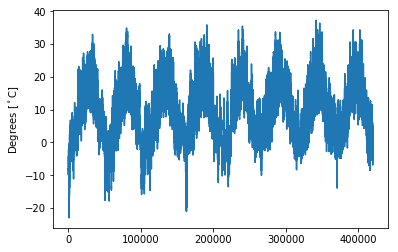

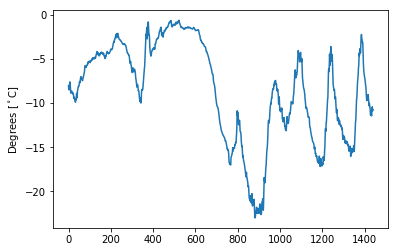

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.ylabel('Degrees [$^\circ$C]')
plt.show()

plt.figure()
plt.plot(range(1440), temp[:1440])
plt.ylabel('Degrees [$^\circ$C]')
plt.show()

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
# Remove

minVal = 10000
maxVal = -10000
j = float_data[300001:, 1]

for i in j:
    if i < minVal:
        minVal = i
    if i > maxVal:
        maxVal = i

print(minVal)
print(maxVal)

-2.5989665445150556
3.185840607054476


In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


<h1>Trivial Models</h1>

In [10]:
from keras import models
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop

model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(lookback // step, float_data.shape[-1])))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(1))
model1.compile(optimizer=RMSprop(), loss='mae')

history1 = model1.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3385 - val_loss: 0.3153
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2449 - val_loss: 0.3558
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2226 - val_loss: 0.3527
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2099 - val_loss: 0.3385
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2002 - val_loss: 0.3499
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1919 - val_loss: 0.3528
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1860 - val_loss: 0.3877
Epoch 8/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1821 - val_loss: 0.3703
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.1773 - val_loss: 0.3548
Epoch 10/20
500/500 [==============================] - 12s 24ms/step - loss: 0.173

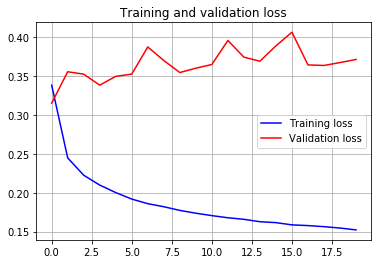

In [11]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs = range(len(loss1))

plt.plot(epochs, loss1, 'b', label='Training loss')
plt.plot(epochs, val_loss1, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [12]:
model1.evaluate_generator(test_gen, steps=250)

0.415297688215971

In [13]:
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1))

model2.compile(optimizer=RMSprop(), loss='mae')
history2 = model2.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 2.0268 - val_loss: 1.3416
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.7973 - val_loss: 0.5395
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3693 - val_loss: 0.3116
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2856 - val_loss: 0.3311
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2624 - val_loss: 0.2984
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2477 - val_loss: 0.3794
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2410 - val_loss: 0.3517
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2353 - val_loss: 0.3109
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2278 - val_loss: 0.3544
Epoch 10/20
500/500 [==============================] - 12s 24ms/step - loss: 0.222

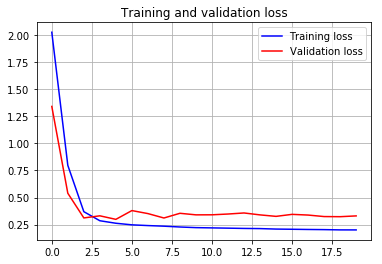

In [14]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(loss2))

plt.plot(epochs, loss2, 'b', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [15]:
model2.evaluate_generator(test_gen, steps=250)

2.748323383897543

<h1>First Sequential Models</h1>

In [16]:
model3 = Sequential()
model3.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model3.add(layers.Dense(1))

model3.compile(optimizer=RMSprop(), loss='mae')
history3 = model3.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 236s 473ms/step - loss: 0.3030 - val_loss: 0.2728
Epoch 2/20
500/500 [==============================] - 234s 469ms/step - loss: 0.2765 - val_loss: 0.2713
Epoch 3/20
500/500 [==============================] - 234s 468ms/step - loss: 0.2625 - val_loss: 0.2766
Epoch 4/20
500/500 [==============================] - 229s 459ms/step - loss: 0.2543 - val_loss: 0.2758
Epoch 5/20
500/500 [==============================] - 227s 454ms/step - loss: 0.2449 - val_loss: 0.2870
Epoch 6/20
500/500 [==============================] - 227s 454ms/step - loss: 0.2406 - val_loss: 0.2837
Epoch 7/20
500/500 [==============================] - 230s 460ms/step - loss: 0.2341 - val_loss: 0.2923
Epoch 8/20
500/500 [==============================] - 232s 463ms/step - loss: 0.2278 - val_loss: 0.2938
Epoch 9/20
500/500 [==============================] - 231s 462ms/step - loss: 0.2216 - val_loss: 0.2946
Epoch 10/20
500/500 [==============================] - 227s 455m

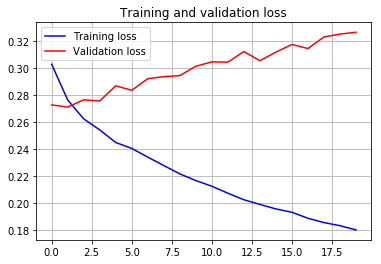

In [17]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs = range(len(loss3))

plt.plot(epochs, loss3, 'b', label='Training loss')
plt.plot(epochs, val_loss3, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [18]:
model3.evaluate_generator(test_gen, steps=250)

0.3082069309353828

In [19]:
model4 = Sequential()
model4.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model4.add(layers.Dense(1))

model4.compile(optimizer=RMSprop(), loss='mae')
history4 = model4.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 182s 363ms/step - loss: 0.2972 - val_loss: 0.2718
Epoch 2/20
500/500 [==============================] - 181s 363ms/step - loss: 0.2831 - val_loss: 0.2676
Epoch 3/20
500/500 [==============================] - 181s 363ms/step - loss: 0.2760 - val_loss: 0.2647
Epoch 4/20
500/500 [==============================] - 181s 362ms/step - loss: 0.2709 - val_loss: 0.2670
Epoch 5/20
500/500 [==============================] - 181s 361ms/step - loss: 0.2656 - val_loss: 0.2679
Epoch 6/20
500/500 [==============================] - 181s 362ms/step - loss: 0.2600 - val_loss: 0.2639
Epoch 7/20
500/500 [==============================] - 181s 363ms/step - loss: 0.2563 - val_loss: 0.2753
Epoch 8/20
500/500 [==============================] - 181s 362ms/step - loss: 0.2516 - val_loss: 0.2669
Epoch 9/20
500/500 [==============================] - 180s 361ms/step - loss: 0.2478 - val_loss: 0.2708
Epoch 10/20
500/500 [==============================] - 181s 362m

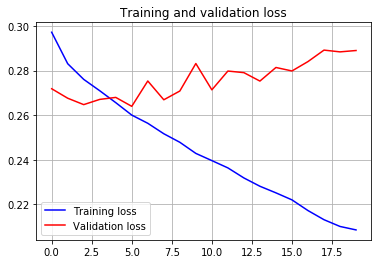

In [20]:
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

epochs = range(len(loss4))

plt.plot(epochs, loss4, 'b', label='Training loss')
plt.plot(epochs, val_loss4, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [21]:
model4.evaluate_generator(test_gen, steps=250)

0.2797236641049385

<h1>Dropout Models</h1>

In [22]:
model5 = Sequential()
model5.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model5.add(layers.Dense(1))

model5.compile(optimizer=RMSprop(), loss='mae')
history5 = model5.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 208s 415ms/step - loss: 0.3417 - val_loss: 0.2813
Epoch 2/40
500/500 [==============================] - 207s 414ms/step - loss: 0.3148 - val_loss: 0.2803
Epoch 3/40
500/500 [==============================] - 207s 414ms/step - loss: 0.3086 - val_loss: 0.2762
Epoch 4/40
500/500 [==============================] - 207s 413ms/step - loss: 0.3039 - val_loss: 0.2691
Epoch 5/40
500/500 [==============================] - 207s 413ms/step - loss: 0.3009 - val_loss: 0.2714
Epoch 6/40
500/500 [==============================] - 207s 414ms/step - loss: 0.2985 - val_loss: 0.2673
Epoch 7/40
500/500 [==============================] - 208s 416ms/step - loss: 0.2960 - val_loss: 0.2695
Epoch 8/40
500/500 [==============================] - 207s 414ms/step - loss: 0.2944 - val_loss: 0.2648
Epoch 9/40
500/500 [==============================] - 207s 414ms/step - loss: 0.2921 - val_loss: 0.2687
Epoch 10/40
500/500 [==============================] - 208s 416m

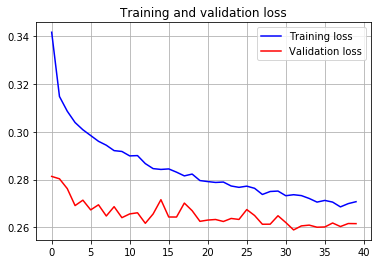

In [23]:
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']

epochs = range(len(loss5))

plt.plot(epochs, loss5, 'b', label='Training loss')
plt.plot(epochs, val_loss5, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [24]:
model5.evaluate_generator(test_gen, steps=250)

0.3094403798878193

<h1>Stacking Models</h1>

In [25]:
model6 = Sequential()
model6.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model6.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model6.add(layers.Dense(1))

model6.compile(optimizer=RMSprop(), loss='mae')
history6 = model6.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 420s 839ms/step - loss: 0.3321 - val_loss: 0.2790
Epoch 2/40
500/500 [==============================] - 418s 836ms/step - loss: 0.3141 - val_loss: 0.2717
Epoch 3/40
500/500 [==============================] - 421s 842ms/step - loss: 0.3047 - val_loss: 0.2700
Epoch 4/40
500/500 [==============================] - 420s 841ms/step - loss: 0.3033 - val_loss: 0.2774
Epoch 5/40
500/500 [==============================] - 424s 848ms/step - loss: 0.2974 - val_loss: 0.2724
Epoch 6/40
500/500 [==============================] - 420s 841ms/step - loss: 0.2960 - val_loss: 0.2678
Epoch 7/40
500/500 [==============================] - 422s 843ms/step - loss: 0.2925 - val_loss: 0.2756
Epoch 8/40
500/500 [==============================] - 420s 841ms/step - loss: 0.2906 - val_loss: 0.2693
Epoch 9/40
500/500 [==============================] - 422s 844ms/step - loss: 0.2864 - val_loss: 0.2695
Epoch 10/40
500/500 [==============================] - 421s 842m

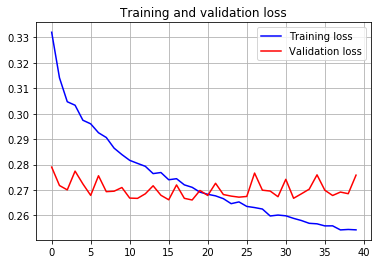

In [26]:
loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']

epochs = range(len(loss6))

plt.plot(epochs, loss6, 'b', label='Training loss')
plt.plot(epochs, val_loss6, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [27]:
model6.evaluate_generator(test_gen, steps=250)

0.31220699289441106

<h1>Bidirectional Models</h1>

In [28]:
model7 = Sequential()
model7.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model7.add(layers.Dense(1))

model7.compile(optimizer=RMSprop(), loss='mae')
history7 = model7.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 359s 719ms/step - loss: 0.2908 - val_loss: 0.2743
Epoch 2/40
500/500 [==============================] - 356s 712ms/step - loss: 0.2746 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 354s 708ms/step - loss: 0.2672 - val_loss: 0.2711
Epoch 4/40
500/500 [==============================] - 354s 708ms/step - loss: 0.2589 - val_loss: 0.2715
Epoch 5/40
500/500 [==============================] - 364s 728ms/step - loss: 0.2525 - val_loss: 0.2735
Epoch 6/40
500/500 [==============================] - 363s 726ms/step - loss: 0.2469 - val_loss: 0.2820
Epoch 7/40
500/500 [==============================] - 361s 722ms/step - loss: 0.2424 - val_loss: 0.2813
Epoch 8/40
500/500 [==============================] - 360s 720ms/step - loss: 0.2363 - val_loss: 0.2789
Epoch 9/40
500/500 [==============================] - 363s 725ms/step - loss: 0.2313 - val_loss: 0.2816
Epoch 10/40
500/500 [==============================] - 361s 721m

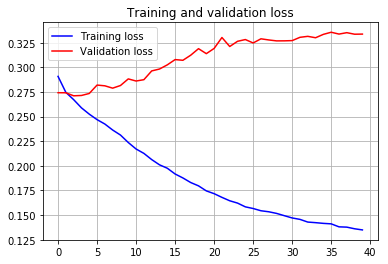

In [29]:
loss7 = history7.history['loss']
val_loss7 = history7.history['val_loss']

epochs = range(len(loss7))

plt.plot(epochs, loss7, 'b', label='Training loss')
plt.plot(epochs, val_loss7, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [30]:
model7.evaluate_generator(test_gen, steps=250)

0.30793926668167115